<a href="https://colab.research.google.com/github/tintenderete/TFM-Algoritmo-con-redes-evolutivas/blob/main/A_individuos_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [198]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import ConvLSTM1D, Dense, Conv2D, LSTM, GRU, Reshape, ConvLSTM2D, Conv3D, TimeDistributed, Flatten
import keras
import tensorflow as tf

In [199]:
import matplotlib.pyplot as plt

# vars

In [200]:
x = np.random.rand(5, 60, 35, 3)
y = np.random.rand(5, 35)

In [201]:
layers = []
dims = []
activations = []

individuos = []
models = []

# GEN mas largo => tipo_layer,  activation=info[0],   filters=info[1],      kernel_size=info[2]
len_gen = 4
num_genes = 5 
size_cadena = len_gen * num_genes
num_individuos = 50

layers_random = []
activations_random = [] 
units_random = []
kernels_size_random = []

rango_minimo_units = 1
rango_maximo_units = 100

rango_minimo_kernel_size = 1
rango_maximo_kernel_size = 4

# layers

In [202]:

layers.append( lambda info : Dense(                     activation=activations[info[0]],   units=info[1] ) )
dims.append(-1)

layers.append( lambda info : TimeDistributed(Dense(     activation=activations[info[0]],   units=info[1] ) ) )
dims.append(4)

layers.append( lambda info : ConvLSTM2D(                activation=activations[info[0]],   filters=info[1],      kernel_size=(info[2],info[2]),                 padding='same'))
dims.append(5)

layers.append( lambda info : ConvLSTM1D(                activation=activations[info[0]],   filters=info[1],      kernel_size=(info[2],),                        padding='same'))
dims.append(4)

layers.append( lambda info : Conv3D(                    activation=activations[info[0]],   filters=info[1],      kernel_size=(info[2],info[2],info[2] ),        padding='same'))
dims.append(5)

layers.append( lambda info : Conv2D(                    activation=activations[info[0]],    filters=info[1],      kernel_size=(info[2],info[2]),                 padding='same'))
dims.append(4)

layers.append( lambda info : LSTM(                                                          units=info[1]))
dims.append(3)

layers.append( lambda info : GRU(                                                           units=info[1]))
dims.append(3)

# activations

In [203]:
activations.append('tanh')

#auxs funcs

In [204]:
def aumenta_dimensions(model):
  return tuple( tf.expand_dims(model, axis=-1).shape[1:].as_list() )

def reduce_dimensions(shape):
  d = list(shape[1:])
  new_shape = d[:-2] + [d[-2] * d[-1]]
  return tuple(new_shape)

# Individuos

In [205]:
layers_random = np.random.randint(-1, len(layers), (num_individuos, num_genes))
activations_random = np.zeros((num_individuos, num_genes), dtype=int)
units_random = np.random.randint(rango_minimo_units, rango_maximo_units, (num_individuos, num_genes))
kernels_size_random = np.random.randint(rango_minimo_kernel_size, rango_maximo_kernel_size, (num_individuos, num_genes))

individuos = np.zeros((num_individuos, size_cadena), dtype=int)
individuos[:,::len_gen] = layers_random
individuos[:,1::len_gen] = activations_random
individuos[:,2::len_gen] = units_random
individuos[:,3::len_gen] = kernels_size_random

## Visualizacion individuo

In [206]:
individuo_ejemplo = [0,3,4,5,7,87,98,23,2,3,4,5,]

In [207]:
for i in range(0, len(individuo_ejemplo), len_gen):
  print(individuo_ejemplo[i:i+len_gen])

[0, 3, 4, 5]
[7, 87, 98, 23]
[2, 3, 4, 5]


In [ ]:
"""
cada gen contiene la informacion necesaria para generar cada layer

[0, 3, 4, 5]
  - layer 0
  - activation 3
  - numero de units 4
  - numero de kernels 5

y asi suvesivamente para cada gen
"""

# Creacion individuos

In [ ]:
"""
El punto clave del planteamiento actual es la linea 33-46.

Donde forzamos que cualquier par de capas sea compatible mediante reshapes.

Con el cruzamiento buscaremos optimizar, su analisis y explicacion es la siguiente etapa

"""

In [211]:
models = []

for ind in individuos:
  

  # Creamos un nuevo modelo para nuestro individuo
  inputs = keras.Input(shape=(x.shape[1:]))
  m = inputs
  ############################################################################

  for i in range(0, len(ind), len_gen):

    # Guardamos el gen entero
    gen = ind[i:i+len_gen]
    
    ############################################################################

    if gen[0] != -1:
      
      # Creamos el nuevo layer
      tipo_layer = gen[0]
      info = gen[1:]
      new_layer = layers[tipo_layer](info)
      dim_layer = dims[tipo_layer]
      ############################################################################

      # Observamos si el output actual del modelo es compatible con la nueva layer #
      current_m_dim = len(m.shape) 
      new_layer_dim = current_m_dim if dim_layer == -1 else dim_layer 
      diferencia = new_layer_dim - current_m_dim
      ############################################################################

      # Hacemos los reshapes necesarios para hacer compatible las dos layers #
      while diferencia != 0:
        
        if diferencia > 0:
          new_d = aumenta_dimensions(m)
          m = Reshape(new_d)(m)
        elif diferencia < 0:
          new_d = reduce_dimensions(m.shape)
          m = Reshape(new_d)(m)
        # recalculamos el output dentro del while para iterar todas las veces necesarias
        current_m_dim = len(m.shape) 
        new_layer_dim = current_m_dim if dim_layer == -1 else dim_layer 
        diferencia = new_layer_dim - current_m_dim
      ##############################################################################

      # Añadimos el nuevo layer al modelo #
      m = new_layer(m)
      ##############################################################################


  # Una vez recorridos todos los genes compilamos el modelo #
  m = Flatten()(m)
  outputs = Dense(y.shape[1])(m)
  model = keras.Model(inputs=inputs, outputs=outputs)
  model.compile(
    loss='mse',
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
  )

  models.append(model)
  ##############################################################################

  

# test de entrenamiento epochs = 1

In [212]:
his = []
for m in models:
  his.append( (m.fit(x,y, epochs=1)).history["accuracy"] )

1/1 [==============================] - 5s 5s/step - loss: 0.2837 - accuracy: 0.0000e+00


## accuracy entre modelos

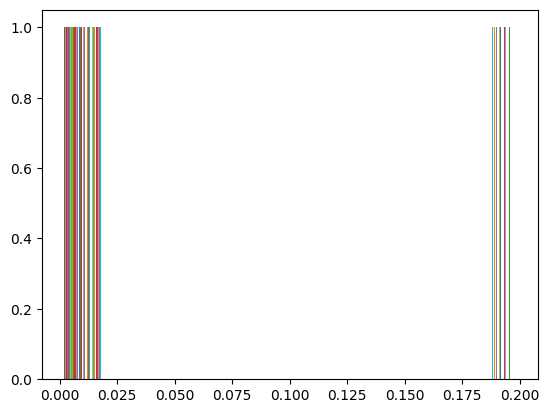

In [213]:
plt.hist(his);

## prediccion de un modelo

In [214]:
y_predict = models[0](x[0:1])

In [215]:
y_predict.shape

TensorShape([1, 35])

In [216]:
y_predict

<tf.Tensor: shape=(1, 35), dtype=float32, numpy=
array([[ 0.00224129,  0.00574608, -0.00073087, -0.0018872 , -0.00018735,
        -0.00145782,  0.00317761,  0.00157147, -0.00174587,  0.0086842 ,
         0.00140737,  0.00512033,  0.0039061 ,  0.00524196,  0.00108455,
         0.00325114,  0.00112239,  0.00365413, -0.00114581, -0.00069472,
        -0.00023736,  0.00094245,  0.00269564,  0.00808065,  0.0057581 ,
        -0.00062614,  0.00194985,  0.00056604,  0.00484314,  0.00606015,
         0.0028792 ,  0.00300451, -0.00050289, -0.00057131,  0.0048173 ]],
      dtype=float32)>

## arquitectura del mejor modelo

In [217]:
mejor_modelo = np.argmax(his)

In [219]:
# accuracy mejor modelo
his[mejor_modelo]

[0.20000000298023224]

In [218]:
models[mejor_modelo].summary()

Model: "model_123"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_133 (InputLayer)      [(None, 60, 35, 3)]       0         
                                                                 
 reshape_429 (Reshape)       (None, 60, 35, 3, 1)      0         
                                                                 
 conv_lstm2d_74 (ConvLSTM2D)  (None, 35, 3, 98)        155624    
                                                                 
 conv_lstm1d_72 (ConvLSTM1D)  (None, 3, 22)            10648     
                                                                 
 gru_72 (GRU)                (None, 67)                18291     
                                                                 
 reshape_430 (Reshape)       (None, 67, 1)             0         
                                                                 
 reshape_431 (Reshape)       (None, 67, 1, 1)          0 

## arquitectura del peor modelo

In [223]:
peor_modelo = np.argmin(his)

In [224]:
# accuracy peor modelo
his[peor_modelo]

[0.0]

In [225]:
models[peor_modelo].summary()

Model: "model_104"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_114 (InputLayer)      [(None, 60, 35, 3)]       0         
                                                                 
 reshape_363 (Reshape)       (None, 60, 35, 3, 1)      0         
                                                                 
 conv3d_53 (Conv3D)          (None, 60, 35, 3, 46)     414       
                                                                 
 conv_lstm2d_60 (ConvLSTM2D)  (None, 35, 3, 67)        272824    
                                                                 
 reshape_364 (Reshape)       (None, 35, 3, 67, 1)      0         
                                                                 
 conv_lstm2d_61 (ConvLSTM2D)  (None, 3, 67, 19)        1596      
                                                                 
 reshape_365 (Reshape)       (None, 3, 1273)           0 